In [20]:
#Import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [21]:
#Load dataset
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/CovidData/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/CovidData/train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 249 files belonging to 3 classes.
Using 200 files for training.
Found 249 files belonging to 3 classes.
Using 49 files for validation.


In [22]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [23]:
class_names = train_ds.class_names
print(class_names)

['Covid', 'Normal', 'Viral Pneumonia']


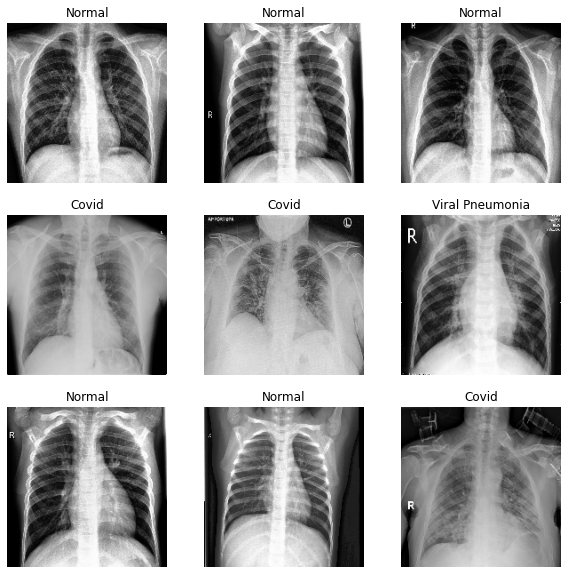

In [24]:
#Visualizing the data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [25]:
#Data augmentation
data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal"),
     layers.experimental.preprocessing.RandomRotation(0.05),
     layers.experimental.preprocessing.RandomZoom(0.10)
    ]
)

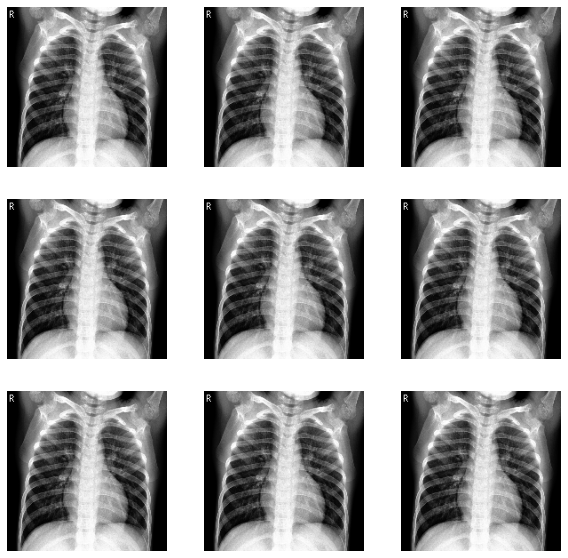

In [26]:
#Images after random augmentation
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [27]:
#Configuring the dataset performance
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

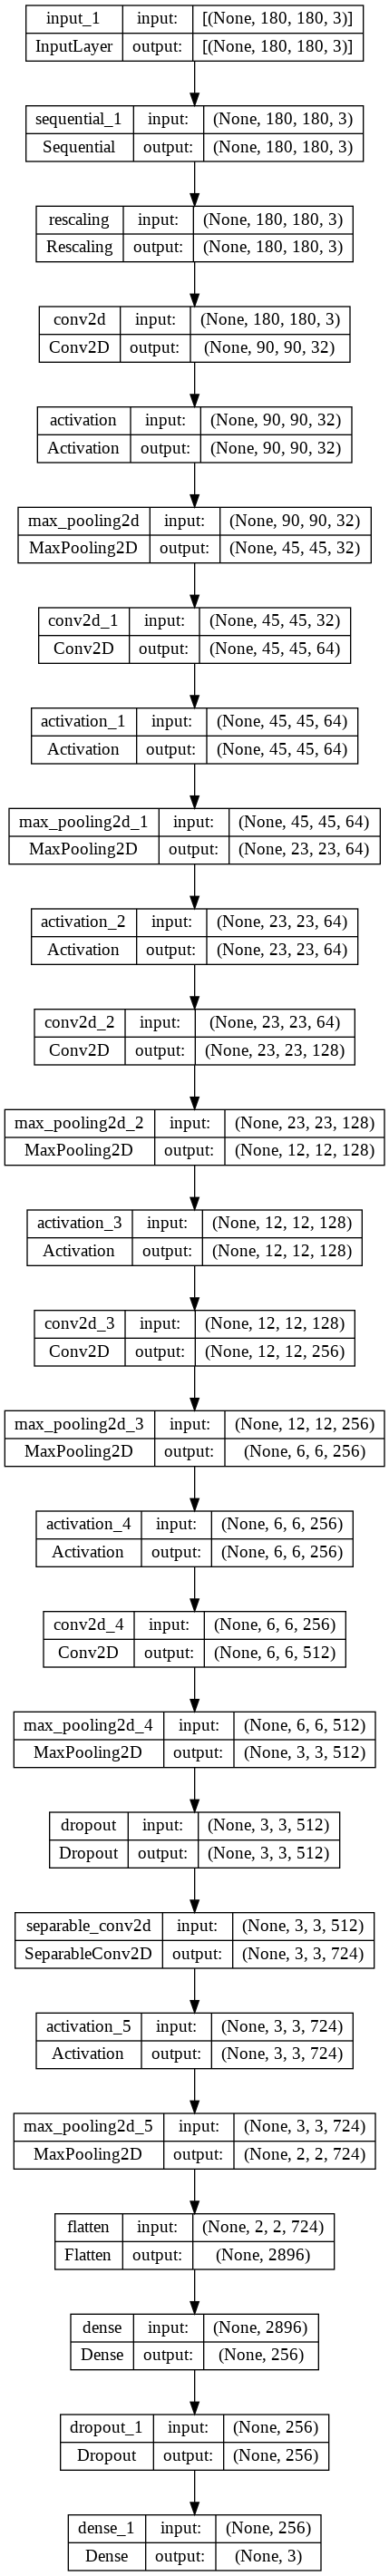

In [28]:
#Building the model
keras.backend.clear_session()

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 5, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Conv2D(64, 5, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    for size in [128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 5, padding="same")(x)
        x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Dropout(0.5)(x)
    x = layers.SeparableConv2D(724, 3, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)

In [29]:
#Defining callbacks
def scheduler(epoch, lr):
  if epoch < 9:
    return lr
  else:
    return lr * tf.math.exp(-0.008)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [30]:
#Training the model
epochs = 50

model.compile(optimizer= keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics = ["accuracy"])

history = model.fit(
    train_ds, epochs = epochs, 
    callbacks = [lr_callback],
    validation_data = val_ds)

Epoch 1/50
7/7 [==============================] - 22s 3s/step - loss: 1.4133 - accuracy: 0.4100 - val_loss: 1.0994 - val_accuracy: 0.2041 - lr: 0.0010
Epoch 2/50
7/7 [==============================] - 21s 2s/step - loss: 1.0980 - accuracy: 0.3350 - val_loss: 1.0964 - val_accuracy: 0.4694 - lr: 0.0010
Epoch 3/50
7/7 [==============================] - 21s 2s/step - loss: 1.0939 - accuracy: 0.4350 - val_loss: 1.0917 - val_accuracy: 0.4694 - lr: 0.0010
Epoch 4/50
7/7 [==============================] - 21s 2s/step - loss: 1.0892 - accuracy: 0.4450 - val_loss: 1.0869 - val_accuracy: 0.4694 - lr: 0.0010
Epoch 5/50
7/7 [==============================] - 23s 3s/step - loss: 1.0886 - accuracy: 0.4400 - val_loss: 1.0810 - val_accuracy: 0.4694 - lr: 0.0010
Epoch 6/50
7/7 [==============================] - 21s 2s/step - loss: 1.0828 - accuracy: 0.4450 - val_loss: 1.0762 - val_accuracy: 0.4694 - lr: 0.0010
Epoch 7/50
7/7 [==============================] - 21s 2s/step - loss: 1.0828 - accuracy: 0.445

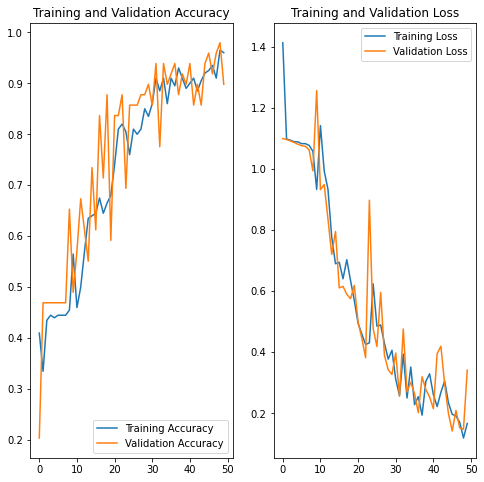

In [31]:
#Plotting the Training and Validation Loss
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
#Predicting the pictures
image_path = "/content/drive/MyDrive/CovidData/validation/pic1.jpeg"
image_path2 = "/content/drive/MyDrive/CovidData/validation/pic2.jpeg"
image_path3 = "/content/drive/MyDrive/CovidData/validation/pic3.jpeg"
image_path4 = "/content/drive/MyDrive/CovidData/validation/pic4.jpeg"
image_path5 = "/content/drive/MyDrive/CovidData/validation/pic5.jpeg"
image_path6 = "/content/drive/MyDrive/CovidData/validation/pic6.jpeg"
image_path7 = "/content/drive/MyDrive/CovidData/validation/pic7.jpg"
image_path8 = "/content/drive/MyDrive/CovidData/validation/pic8.jpeg"
image_path9 = "/content/drive/MyDrive/CovidData/validation/pic9.jpeg"
image_path10 = "/content/drive/MyDrive/CovidData/validation/pic10.jpeg"
merged_path = [image_path,image_path2,image_path3,image_path4,image_path5,image_path6,image_path7,image_path8,image_path9,image_path10]

for img_path in merged_path:
    img = keras.preprocessing.image.load_img(
        img_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score)))

1/1 [==============================] - 0s 139ms/step
This image most likely belongs to Normal with a 57.40 percent confidence.
1/1 [==============================] - 0s 40ms/step
This image most likely belongs to Normal with a 46.40 percent confidence.
1/1 [==============================] - 0s 46ms/step
This image most likely belongs to Viral Pneumonia with a 57.61 percent confidence.
1/1 [==============================] - 0s 51ms/step
This image most likely belongs to Viral Pneumonia with a 57.61 percent confidence.
1/1 [==============================] - 0s 42ms/step
This image most likely belongs to Normal with a 56.91 percent confidence.
1/1 [==============================] - 0s 45ms/step
This image most likely belongs to Covid with a 57.60 percent confidence.
1/1 [==============================] - 0s 38ms/step
This image most likely belongs to Covid with a 57.58 percent confidence.
1/1 [==============================] - 0s 49ms/step
This image most likely belongs to Viral Pneumonia